In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.svm as svm

%pwd

# load toy data
toy = np.load('../data/toy-data.npz')
t_data = toy['training_data']
t_labels = toy['training_labels']
w = np.array([-0.4528, -0.5190])
b = 0.1471

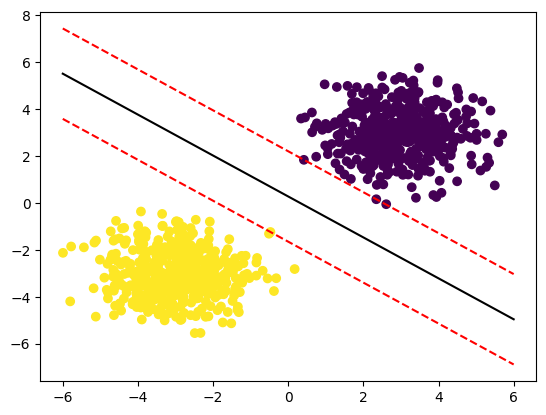

In [2]:
# plot data
plt.scatter(t_data[:, 0], t_data[:, 1], c=t_labels)

# plot the decision boundary
x = np.linspace(-6, 6, 100)
y = -(w[0] * x + b) / w[1]

plt.plot(x, y, 'k')

# plot the margin
m_pos = (1 - b - w[0]*x)/w[1]
m_neg = (-1 - b - w[0]*x)/w[1]
plt.plot(x, m_pos, 'r--')
plt.plot(x, m_neg, 'r--')


plt.show()


In [3]:
def partition_data(data, labels, validation_size=10000):
    """
    shuffle and split dataset into training and validation set without sklearn
    
    args:
        data (numpy.ndarray): input data with num_samples as the first dimension
        labels (numpy.ndarray): input labels with shape of (num_samples, 1)
        validation_size (int): number of validation examples
    
    returns:
        tuple: training data, training labels, validation data, validation labels
    """
    # number of samples
    num_samples = data.shape[0]
    
    # generate a shuffled index array
    indices = np.arange(num_samples)
    np.random.seed(42)  
    np.random.shuffle(indices)
    
    # shuffle data and labels using the shuffled indices
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]
    
    # split the shuffled dataset into training and validation sets
    validation_data = shuffled_data[:validation_size]
    validation_labels = shuffled_labels[:validation_size]
    training_data = shuffled_data[validation_size:]
    training_labels = shuffled_labels[validation_size:]
    
    return training_data, training_labels, validation_data, validation_labels
def eval_accuracy(predicted_labels, true_labels):
    """
    evaluate the accuracy of the predicted labels
    
    args:
        predicted_labels (numpy.ndarray): predicted labels
        true_labels (numpy.ndarray): true labels
        
    returns:
        float: accuracy
    """
    return np.mean(predicted_labels == true_labels)

In [4]:
# load MNIST data
mnist = np.load('../data/mnist-data.npz')
mnist_train_data = mnist['training_data']
mnist_labels = mnist['training_labels']
mnist_test_data = mnist['test_data']

# partition MNIST data
mnist_X_train, mnist_y_train, mnist_X_val, mnist_y_val = partition_data(mnist_train_data, mnist_labels, validation_size=10000)
print(mnist_X_train.shape)
print(mnist_X_val.shape)
print(mnist_y_train.shape)
print(mnist_y_val.shape)

(50000, 1, 28, 28)
(10000, 1, 28, 28)
(50000,)
(10000,)


In [5]:
# load spam data
spam = np.load('../data/spam-data.npz')
spam_train_data = spam['training_data']
spam_labels = spam['training_labels']
spam_test_data = spam['test_data']

# partition spam data
spam_X_train, spam_y_train, spam_X_val, spam_y_val = partition_data(spam_train_data, spam_labels, validation_size=int(0.20*spam_train_data.shape[0]))
print(spam_X_train.shape)
print(spam_X_val.shape)
print(spam_y_train.shape)
print(spam_y_val.shape)

(3337, 32)
(834, 32)
(3337,)
(834,)


In [6]:
def prepare_training_data(data, labels, train_sizes, validation_size=10000):
    """
    shuffle and split dataset for varying training sizes and a fixed validation set.
    
    Args:
        data (numpy.ndarray): input data (will be converted to 2D if not already).
        labels (numpy.ndarray): labels of shape (samples,)
        train_sizes (list of int): list of training set sizes (e.g., [100, 200, 500, ...]).
        validation_size (int): num of validation examples.
    
    Returns:
        dict: A dictionary where keys are training sizes and values are tuples:
              (training data, training labels, validation data, validation labels).
    """
    # shuffle the dataset
    np.random.seed(42)
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    if len(data.shape) != 2:  # e.g. (samples, 1, 28, 28)
        data = data.reshape(data.shape[0], -1)
    elif len(data.shape) == 2:  # already (samples, features)
        pass
    else:
        raise ValueError("Unsupported input shape: {}".format(data.shape))
    
    # validation set
    validation_data = data[:validation_size]
    validation_labels = labels[:validation_size]
    
    # create training subsets
    results = {}
    for size in train_sizes:
        train_data = data[validation_size:validation_size + size]
        train_labels = labels[validation_size:validation_size + size]
        results[size] = (train_data, train_labels, validation_data, validation_labels)
    
    return results

In [ ]:
# partioning into smaller training batches

train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

partitions = prepare_training_data(mnist_train_data, mnist_labels, train_sizes)

for size in train_sizes:
    train_data, train_labels, val_data, val_labels = partitions[size]
    print(f"Training size: {size}, Training Data Shape: {train_data.shape}, Validation Data Shape: {val_data.shape}")

Training size: 100, Training Data Shape: (100, 784), Validation Data Shape: (10000, 784)
Training size: 200, Training Data Shape: (200, 784), Validation Data Shape: (10000, 784)
Training size: 500, Training Data Shape: (500, 784), Validation Data Shape: (10000, 784)
Training size: 1000, Training Data Shape: (1000, 784), Validation Data Shape: (10000, 784)
Training size: 2000, Training Data Shape: (2000, 784), Validation Data Shape: (10000, 784)
Training size: 5000, Training Data Shape: (5000, 784), Validation Data Shape: (10000, 784)
Training size: 10000, Training Data Shape: (10000, 784), Validation Data Shape: (10000, 784)


In [ ]:
# nonlinear SVM
 
for size in train_sizes:
    clf = svm.SVC()
    clf.fit(partitions[size][0], partitions[size][1])
    predictions = clf.predict(partitions[size][2])
    print("Accuracy for ", size, ": ",  eval_accuracy(predictions, partitions[size][3]))

Accuracy for  100 :  0.6493
Accuracy for  200 :  0.8217
Accuracy for  500 :  0.8931
Accuracy for  1000 :  0.9113
Accuracy for  2000 :  0.9323
Accuracy for  5000 :  0.9496
Accuracy for  10000 :  0.9618


In [ ]:
# linear SVM

for size in train_sizes:
    clf = svm.SVC(kernel='linear')
    # clf = svm.LinearSVC() # seems to be much slower
    clf.fit(partitions[size][0], partitions[size][1])
    predictions = clf.predict(partitions[size][2])
    print("Accuracy for", size, ": ", eval_accuracy(predictions, partitions[size][3]))

Accuracy for 100 :  0.7511
Accuracy for 200 :  0.8133
Accuracy for 500 :  0.8646
Accuracy for 1000 :  0.8776
Accuracy for 2000 :  0.8955
Accuracy for 5000 :  0.8999
Accuracy for 10000 :  0.9079


Accuracy for  1e-08 :  0.8932
Accuracy for  1e-07 :  0.9232
Accuracy for  1e-06 :  0.9315
Accuracy for  1e-05 :  0.9146
Accuracy for  0.0001 :  0.9081
Accuracy for  0.001 :  0.9079
Accuracy for  0.01 :  0.9079
Accuracy for  0.1 :  0.9079
Accuracy for  1.0 :  0.9079
Accuracy for  10.0 :  0.9079


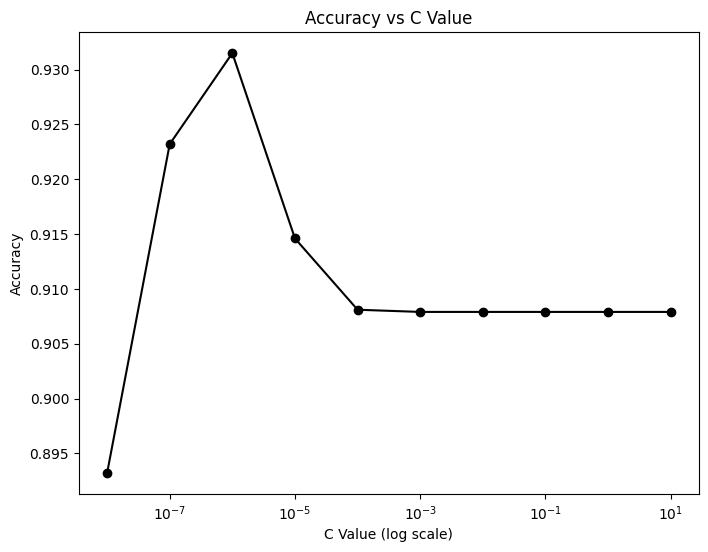

In [10]:
# accuracy vs regularization parameter C

C_vals = []
accuracies = []
for C_val in np.logspace(-8, 1, num=10, base=10.0):
    clf = svm.SVC(C=C_val, kernel='linear')
    clf.fit(partitions[10000][0], partitions[10000][1])
    predictions = clf.predict(partitions[10000][2])
    accuracy = eval_accuracy(predictions, partitions[10000][3])
    print("Accuracy for ", C_val, ": ", accuracy)
    C_vals.append(C_val)
    accuracies.append(accuracy)
plt.figure(figsize=(8, 6))
plt.plot(C_vals, accuracies,'k', marker='o')
plt.xscale('log')  # Logarithmic scale for C values
plt.xlabel('C Value (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C Value')
plt.show()

Training size: 100, Training Data Shape: (100, 32), Validation Data Shape: (834, 32)
Training size: 200, Training Data Shape: (200, 32), Validation Data Shape: (834, 32)
Training size: 500, Training Data Shape: (500, 32), Validation Data Shape: (834, 32)
Training size: 1000, Training Data Shape: (1000, 32), Validation Data Shape: (834, 32)
Training size: 2000, Training Data Shape: (2000, 32), Validation Data Shape: (834, 32)
Training size: 4171, Training Data Shape: (3337, 32), Validation Data Shape: (834, 32)
Accuracy for  100 :  0.6834532374100719
Accuracy for  200 :  0.7050359712230215
Accuracy for  500 :  0.7302158273381295
Accuracy for  1000 :  0.749400479616307
Accuracy for  2000 :  0.7745803357314148
Accuracy for  4171 :  0.7829736211031175
Accuracy for 100 :  0.7709832134292566
Accuracy for 200 :  0.7733812949640287
Accuracy for 500 :  0.7709832134292566
Accuracy for 1000 :  0.7853717026378897
Accuracy for 2000 :  0.7877697841726619
Accuracy for 4171 :  0.7829736211031175
Accur

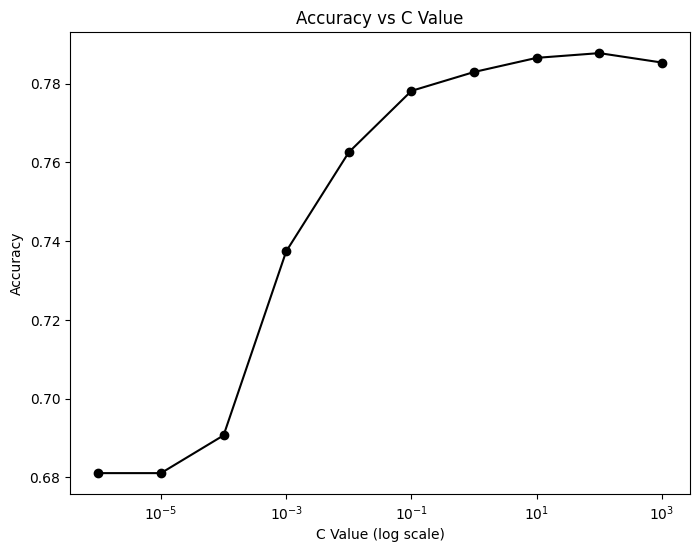

In [11]:
# same  as above but for spam data

#partioning into smaller training batches
spam_train_sizes = [100, 200, 500, 1000, 2000, spam_train_data.shape[0]]
spam_partitions = prepare_training_data(spam_train_data, spam_labels, spam_train_sizes, validation_size=int(0.2*spam_train_data.shape[0]))

for size in spam_train_sizes:
    train_data, train_labels, val_data, val_labels = spam_partitions[size]
    print(f"Training size: {size}, Training Data Shape: {train_data.shape}, Validation Data Shape: {val_data.shape}")

# nonlinear SVM
for size in spam_train_sizes:
    clf = svm.SVC()
    clf.fit(spam_partitions[size][0], spam_partitions[size][1])
    predictions = clf.predict(spam_partitions[size][2])
    print("Accuracy for ", size, ": ",  eval_accuracy(predictions, spam_partitions[size][3]))

# linear SVM
for size in spam_train_sizes:
    clf = svm.SVC(kernel='linear')
    clf.fit(spam_partitions[size][0], spam_partitions[size][1])
    predictions = clf.predict(spam_partitions[size][2])
    print("Accuracy for", size, ": ", eval_accuracy(predictions, spam_partitions[size][3]))

# accuracy vs regularization parameter C
C_vals = []
accuracies = []
for C_val in np.logspace(-6, 3, num=10, base=10.0):
    clf = svm.SVC(C=C_val, kernel='linear')
    clf.fit(spam_partitions[spam_train_sizes[-1]][0], spam_partitions[spam_train_sizes[-1]][1])
    predictions = clf.predict(spam_partitions[spam_train_sizes[-1]][2])
    accuracy = eval_accuracy(predictions, spam_partitions[spam_train_sizes[-1]][3])
    print("Accuracy for ", C_val, ": ", accuracy)
    C_vals.append(C_val)
    accuracies.append(accuracy)
plt.figure(figsize=(8, 6)) 
plt.plot(C_vals, accuracies,'k', marker='o')
plt.xscale('log')  # Logarithmic scale for C values
plt.xlabel('C Value (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C Value')
plt.show()